In [6]:
#Imports
import numpy as np
from itertools import product
import math
from scipy.sparse import kron, csr_matrix
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
import qutip.piqs as piqs
from qutip import mesolve, expect
from scipy.sparse.linalg import expm_multiply
from scipy.sparse import csc_matrix,csr_matrix,lil_matrix
import time

In [7]:
# Number of qubits
N=20

# Initial state parameters |theta,phi>
theta = np.pi/2
phi = np.pi/2

# Lindblad parameters
gamma=0.8            #Decay rate
k=0.1                 #Pumping rate
gamma_phi=0.3         #Dephasing rate
gamma_col=0       #Collective Decay rate
k_col=0             #Collective Pumping rate
gamma_phi_col=0     #Collective Dephasing rate

In [ ]:
start_time_code=time.time()

#Creating the number basis class
class SymmetricLiouvilleQubitNumberBasis:
    def __init__(self, N):
        self.N = N
        self.q = 2
        self.d = self.q ** 2
        self.basis = self._generate_basis()
        self.index_map = {tuple(state): i for i, state in enumerate(self.basis)}

    def _generate_basis(self):
        def compositions(n, k):
            if k == 1:
                yield (n,)
            else:
                for i in range(n + 1):
                    for rest in compositions(n - i, k - 1):
                        yield (i,) + rest

        basis = list(compositions(self.N, self.d))
        basis.reverse()  
        return basis

    def dim(self):
        return len(self.basis)

    def get_index(self, n_tuple):
        return self.index_map.get(tuple(n_tuple), -1)

    def show_basis(self, compact=True):
        for i, state in enumerate(self.basis):
            if compact:
                print(f"{i}: {state}")
            else:
                mat = np.array(state).reshape(self.q, self.q)
                print(f"{i}:\n{mat}\n")

Numberbasis=SymmetricLiouvilleQubitNumberBasis(N)

#This is just to check if any modification is being shown or not

#Defining the collective operators
def collective_J_right(x,y):
    L= lil_matrix((Numberbasis.dim(),Numberbasis.dim()))

    for idx,n in enumerate(Numberbasis.basis):  
        nij=np.array(n).reshape(2,2)

        if x!=y:

            for k in range(2):
                n_copy = nij.copy()
                n_copy[x,k] += 1
                n_copy[y,k] -= 1
           
                new_index = Numberbasis.get_index(n_copy.flatten())
           
                if new_index != -1:
                    L[idx,new_index]+=(nij[x,k]+1) if nij[y,k] > 0 else 0
    
        elif x==y:

            for k in range(2):
                L[idx,idx]+=nij[x,k]
                  
    return L

def collective_J_left(x,y):
    M= lil_matrix((Numberbasis.dim(),Numberbasis.dim()))
    for idx,n in enumerate(Numberbasis.basis):  
        nij=np.array(n).reshape(2,2)

        if x!=y:
            for k in range(2):
                n_copy = nij.copy()
                n_copy[k,x] -= 1
                n_copy[k,y] += 1
           
                new_index = Numberbasis.get_index(n_copy.flatten())
           
                if new_index != -1:
                    M[idx,new_index]+=(nij[k,y]+1) if nij[k,x] > 0 else 0

        elif x==y:
            for k in range(2):
                M[idx,idx]+=nij[k,x]

    return M

J_right11=collective_J_right(1,1)
J_right00=collective_J_right(0,0)
J_right10=collective_J_right(1,0)
J_right01=collective_J_right(0,1)  
J_left11=collective_J_left(1,1)
J_left00=collective_J_left(0,0)
J_left10=collective_J_left(1,0)
J_left01=collective_J_left(0,1)

collective_Jz_right=0.5*(J_right11 - J_right00)

collective_Jz_left=0.5*(J_left11 - J_left00)

collective_Jy_right=0.5j*(J_right10 - J_right01)

collective_Jy_left=0.5j*(J_left10 - J_left01)

collective_Jx_right=0.5*(J_right10 + J_right01)

collective_Jx_left=0.5*(J_left10 + J_left01)


#Initialization of an arbitary |theta,phi> state
P_values0=np.zeros(Numberbasis.dim())
P_values0[0]=1
P_values=P_values0.copy()

 #Taking to arbitary theta

if theta != 0:
    H=(collective_Jy_right-collective_Jy_left)*1j
    
    P_values=expm_multiply(H, P_values0, 0, theta, 2)[-1]

 #Taking to arbitary phi
if phi != 0:
    H=(collective_Jz_right-collective_Jz_left)*1j
    P_values0=P_values.copy()
    P_values=expm_multiply(H, P_values0, 0, phi, 2)[-1]


#Constructing the Entire Liouvillian

#Hamiltonian=lil_matrix((Numberbasis.dim(),Numberbasis.dim()))              #Hamiltonian
#H_commutation=(J_left10@J_left01-J_right10@J_right01)*-1j


#Defining the rate of change of P values
dP_dt=lil_matrix((Numberbasis.dim(),Numberbasis.dim()))
print(dP_dt)
for idx, n in enumerate(Numberbasis.basis):
    nij=np.array(n).reshape(2,2)


    #For decay
    if gamma!=0:
        nij_copy=nij.copy()
        nij_copy[1,1]+=1
        nij_copy[0,0]-=1

        i=Numberbasis.get_index(nij_copy.flatten())
   
        dP_dt[idx,idx]+=-gamma/2*((2*nij[1,1]+nij[1,0]+nij[0,1]))

        if i!=-1:
            dP_dt[idx,i]+=gamma/2*(2*(nij[1,1]+1))



    #For pumping
    if k!=0:
        nij_copy=nij.copy()
        nij_copy[1,1]-=1
        nij_copy[0,0]+=1

        j=Numberbasis.get_index(nij_copy.flatten())

        dP_dt[idx,idx]+=-k/2*((2*nij[0,0]+nij[1,0]+nij[0,1]))

        if j!=-1:
            dP_dt[idx,j]+=k/2*(2*(nij[0,0]+1))


    #For dephasing
    if gamma_phi!=0:
        dP_dt[idx,idx]+=-gamma_phi/2*(nij[1,0]+nij[0,1])


    
#For collective Decay
if gamma_col!=0:
    dP_dt+=gamma_col/2*(2*J_left01@J_right10-J_left10@J_left01-J_right01@J_right10)

#For collective Pumping
if k_col!=0:
    dP_dt+=k_col/2*(2*J_left10@J_right01-J_left01@J_left10-J_right10@J_right01)

#For collective Dephasing
if gamma_phi_col!=0:
    dP_dt+=gamma_phi_col/2*(2*collective_Jz_left@collective_Jz_right-collective_Jz_left@collective_Jz_left-collective_Jz_right@collective_Jz_right)


dP_dt=dP_dt


#Time parameters
t_final=5
t_steps=100
t_eval = np.linspace(0, t_final, t_steps)

P_values0=P_values.copy()
Pt=expm_multiply(dP_dt, P_values0, 0, t_final, t_steps).transpose()

#Defining the observables
#Extracting <J11>
index_list=[]
for idx,n in enumerate(Numberbasis.basis):
    nij=np.array(n).reshape(2,2)
   

    if nij[0,0]+nij[1,1]==N:
        index_list.append(idx)


J11=0*Pt[0]


for i in range(1,len(index_list)):
    J11+=i*Pt[index_list[i]]    #Population of the excited state

J00=N-J11  #Population of the ground state
Jz=J11-N/2 # Expectation of Jz values


# Getting J01
J01 = 0
for idx, n in enumerate(Numberbasis.basis):
    nij = np.array(n).reshape(2,2)   # nij[0,1] is n01
    n01 = nij[1,0]
    J01 += n01 * Pt[idx]
    

# Getting J10
J10 = 0
for idx, n in enumerate(Numberbasis.basis):
    nij = np.array(n).reshape(2,2)   # nij[1,0] is n10
    n10 = nij[0,1]
    J10 += n10 * Pt[idx]

# Spin components
Jx = 0.5 * (J10 + J01)
Jy = 0.5j * (J10 - J01)


end_time_code=time.time()
print("Time taken for the entire code to run: ",end_time_code-start_time_code)


Time taken for the entire code to run:  0.7484557628631592


In [9]:
#PIQS Simulation
start_time_piqs=time.time()
[jx , jy , jz] = piqs.jspin (N)
piqs_sys = piqs.Dicke(N=N, pumping=k,emission=gamma, dephasing=gamma_phi, collective_emission=gamma_col, collective_pumping=k_col)

#H=jz**2

#D=piqs_sys.liouvillian()+(-1j*piqs.spre(H)+1j*piqs.spost(H))

D=piqs_sys.liouvillian()
#rho0_piqs = piqs.ghz(N)
#rho0_piqs = piqs.dicke (N,N/2,-N/2)
rho0_piqs = piqs.css (N,np.pi-theta,-phi,basis="dicke",coordinates="polar")

result = mesolve (D , rho0_piqs , t_eval,[])
rhot = result.states
jzt = expect (rhot , jz)
piqs_pop_n11 = [i+N/2 for i in jzt]
piqs_pop_n00 = [N - i for i in piqs_pop_n11]

jxt = expect (rhot , jx)
jyt= expect (rhot , jy)

end_time_piqs=time.time()
print("Time taken for PIQS to run: ",end_time_piqs-start_time_piqs)

Time taken for PIQS to run:  0.3751220703125


c:\Users\sayan\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\sayan\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


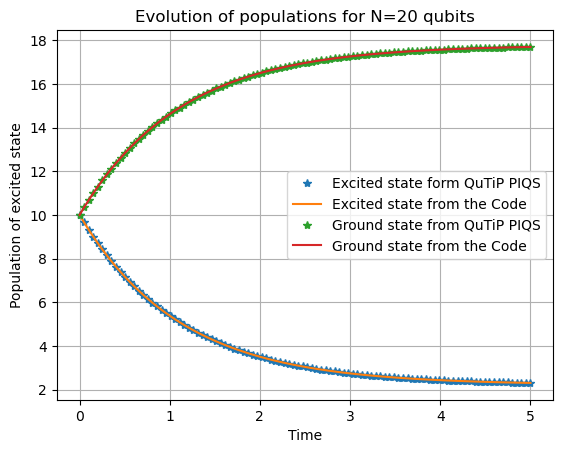

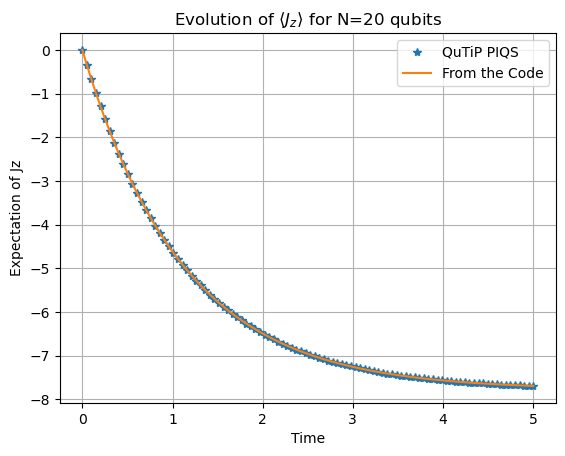

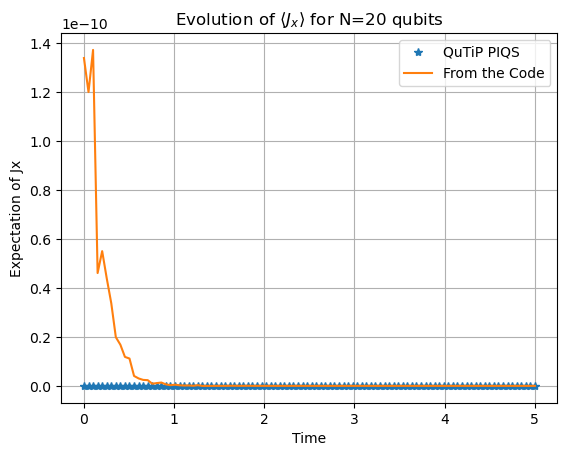

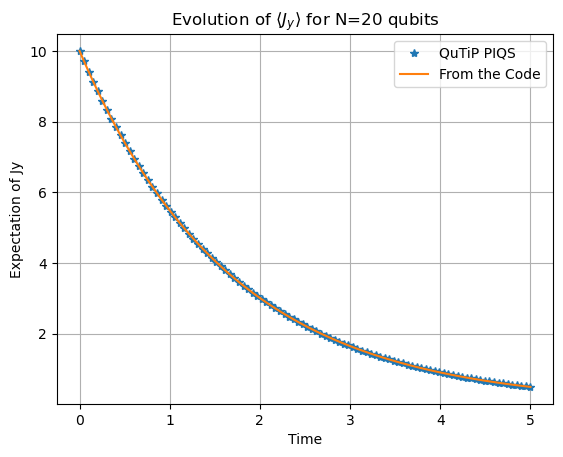

In [10]:
#Comparison Plotting
plt.plot(t_eval, piqs_pop_n11, '*', label='Excited state form QuTiP PIQS')
plt.plot(t_eval, J11, label="Excited state from the Code")


plt.plot(t_eval, piqs_pop_n00, '*', label='Ground state from QuTiP PIQS')
plt.plot(t_eval, J00, label="Ground state from the Code")


plt.xlabel("Time")
plt.ylabel("Population of excited state")
plt.title(r"Evolution of populations for N="+str(N)+" qubits")
plt.grid(True)
plt.legend()
plt.show()


plt.plot(t_eval, jzt, '*', label='QuTiP PIQS')
plt.plot(t_eval, Jz, label="From the Code")


plt.xlabel("Time")
plt.ylabel("Expectation of Jz")
plt.title(r"Evolution of $\langle J_z \rangle$ for N="+str(N)+" qubits")
plt.grid(True)
plt.legend()
plt.show()

plt.plot(t_eval, jxt, '*', label='QuTiP PIQS')
plt.plot(t_eval, Jx, label="From the Code")


plt.xlabel("Time")
plt.ylabel("Expectation of Jx")
plt.title(r"Evolution of $\langle J_x \rangle$ for N="+str(N)+" qubits")
plt.grid(True)
plt.legend()
plt.show()


plt.plot(t_eval, jyt, '*', label='QuTiP PIQS')
plt.plot(t_eval, Jy, label="From the Code")


plt.xlabel("Time")
plt.ylabel("Expectation of Jy")
plt.title(r"Evolution of $\langle J_y \rangle$ for N="+str(N)+" qubits")
plt.grid(True)
plt.legend()
plt.show()
